# Otro test 

In [1]:
project_dir = os.path.split(os.getcwd())[0]
if project_dir not in sys.path:
    sys.path.append(project_dir)

ipdl_dir = os.path.join(project_dir, "ipdl/")
if ipdl_dir not in sys.path:
    sys.path.append(ipdl_dir)

In [2]:
import torch
from torch import tensor, Tensor
from torch import nn

from IPAE import SDAE

In [3]:
from IPDL import MatrixBasedRenyisEntropy
from IPAE import MatrixEstimator

class InformationPlane():
    '''
        Pass a list of tensor which contents the matrices in order to calculate the
        MutualInformation
    '''
    def __init__(self, matrix_estimator: list):
        if not all(isinstance(n, MatrixEstimator) for n in matrix_estimator):
            #lanzar error
            pass

        # First element corresponds to input A matrix and last element
        # is the output A matrix
        self.matrices_per_layers = matrix_estimator
        self.Ixt = []
        self.Ity = []
        for i in range(len(matrix_estimator)-2):
            self.Ixt.append([])
            self.Ity.append([])
    
    def calculate_mi(self):
        Ax = self.matrices_per_layers[0].A
        Ay = self.matrices_per_layers[-1].A

        for idx, matrix_estimator in enumerate(self.matrices_per_layers[1:-1]):
            self.Ixt[idx].append(MatrixBasedRenyisEntropy.mutualInformation(Ax, matrix_estimator.A).cpu())
            self.Ity[idx].append(MatrixBasedRenyisEntropy.mutualInformation(matrix_estimator.A, Ay).cpu())

    def get_mi(self):
        return self.Ixt, self.Ity

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = SDAE([28*28, 1000, 500, 250, 24], dropout=False).to(device)

In [5]:
print(model)

SDAE(
  (sdae): Sequential(
    (0): MatrixEstimator()
    (1): Sequential(
      (0): Linear(in_features=784, out_features=1000, bias=True)
      (1): ReLU(inplace=True)
      (2): MatrixEstimator()
    )
    (2): Sequential(
      (0): Linear(in_features=1000, out_features=500, bias=True)
      (1): ReLU(inplace=True)
      (2): MatrixEstimator()
    )
    (3): Sequential(
      (0): Linear(in_features=500, out_features=250, bias=True)
      (1): ReLU(inplace=True)
      (2): MatrixEstimator()
    )
    (4): Sequential(
      (0): Linear(in_features=250, out_features=24, bias=True)
      (1): MatrixEstimator()
    )
    (5): Sequential(
      (0): Linear(in_features=24, out_features=250, bias=True)
      (1): ReLU(inplace=True)
      (2): MatrixEstimator()
    )
    (6): Sequential(
      (0): Linear(in_features=250, out_features=500, bias=True)
      (1): ReLU(inplace=True)
      (2): MatrixEstimator()
    )
    (7): Sequential(
      (0): Linear(in_features=500, out_features=1000, 

# Training

In [6]:
from torch.utils.data import DataLoader
import torchvision
from torchvision.transforms import Compose, ToTensor, Normalize, Lambda
from torchvision.utils import save_image
from tqdm import tqdm

device = 'cuda' if torch.cuda.is_available() else 'cpu'

transformToTensor = Compose([
            ToTensor(), # first, convert image to PyTorch tensor
            # Normalize((0.5,), (0.5,)),
            Normalize((0.1307,), (0.3081,)), # normalize inputs
            Lambda(lambda x: torch.flatten(x)) # Auto-flatten
        ])

train_dataset = torchvision.datasets.MNIST("../datasets/MNIST/", train=True, download=True, transform=transformToTensor)
dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=0)

test_dataset = torchvision.datasets.MNIST("../datasets/MNIST/", train=False, download=False, transform=transformToTensor)
test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False, num_workers=0) 

model = model.to(device)

## Layer-wise training

In [7]:
for epoch in tqdm(range(3)):
    for inputs, targets in dataloader:
        inputs = inputs.to(device)
        model.layer_wise_training(inputs)

100%|██████████| 3/3 [00:41<00:00, 13.86s/it]


## SDAE Training

## Calculating Mutual Information during Training

In [7]:
n_epoch = 10
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 30, gamma=0.1)

model.train()

eval_inputs, _ = next(iter(test_loader))
eval_inputs = eval_inputs.to(device)

epoch_iterator = tqdm(
    range(n_epoch),
    leave=True,
    unit="epoch",
    postfix={"lss": "%.6f" % 0.0, "vls": "%.6f" % -1,},
)

ip = InformationPlane(model.get_matrix())

for epoch in epoch_iterator:
    for idx, (inputs, _) in enumerate(dataloader):
        inputs = inputs.flatten(1).to(device)

        optimizer.zero_grad()

        outputs = model(inputs)

        loss = criterion(outputs, inputs)
        loss_value = float(loss.item())        
        loss.backward()

        optimizer.step()

        if idx % 25 == 0:
            model.eval()
            outputs = model(eval_inputs.flatten(1))
            eval_loss_value = float((criterion(outputs, eval_inputs.flatten(1))).item())
            epoch_iterator.set_postfix(
                lss="%.6f" % loss_value, vls="%.6f" % eval_loss_value,
            )
            model.train()
    
    scheduler.step()
    
    ip.calculate_mi()

100%|██████████| 10/10 [02:31<00:00, 15.15s/epoch, lss=0.125820, vls=0.135111]


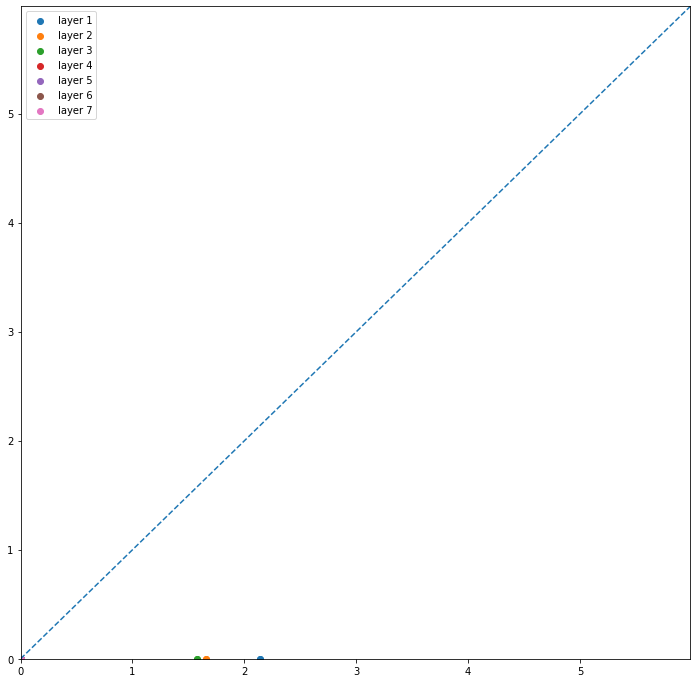

In [9]:
from matplotlib import pyplot as plt

f, ax = plt.subplots(figsize=(12, 12))
reference = MatrixBasedRenyisEntropy.entropy(model.get_matrix()[0].A).cpu()
ax.set(xlim=(0, reference), ylim=(0, reference))

Ixt, Ity = ip.get_mi()
for idx in range(len(Ixt)):
    # if idx < 3:
    #     continue
    current_Ixt = Ixt[idx]
    current_Ity = Ity[idx]
    ax.scatter(current_Ixt, current_Ity, label="layer {}".format(idx+1))

ax.plot([0, 1], [0, 1], transform=ax.transAxes, linestyle='dashed')
plt.legend()
f.show()

In [25]:
Ax = ip.matrices_per_layers[0].A
Ay = ip.matrices_per_layers[-1].A

In [26]:
print(Ax)

tensor([[0.0010, 0.0003, 0.0004,  ..., 0.0005, 0.0003, 0.0003],
        [0.0003, 0.0010, 0.0003,  ..., 0.0002, 0.0002, 0.0002],
        [0.0004, 0.0003, 0.0010,  ..., 0.0004, 0.0003, 0.0003],
        ...,
        [0.0005, 0.0002, 0.0004,  ..., 0.0010, 0.0002, 0.0003],
        [0.0003, 0.0002, 0.0003,  ..., 0.0002, 0.0010, 0.0003],
        [0.0003, 0.0002, 0.0003,  ..., 0.0003, 0.0003, 0.0010]])


In [27]:
print(Ay)

tensor([[0.0010, 0.0003, 0.0005,  ..., 0.0007, 0.0005, 0.0004],
        [0.0003, 0.0010, 0.0005,  ..., 0.0004, 0.0004, 0.0004],
        [0.0005, 0.0005, 0.0010,  ..., 0.0006, 0.0005, 0.0005],
        ...,
        [0.0007, 0.0004, 0.0006,  ..., 0.0010, 0.0005, 0.0005],
        [0.0005, 0.0004, 0.0005,  ..., 0.0005, 0.0010, 0.0005],
        [0.0004, 0.0004, 0.0005,  ..., 0.0005, 0.0005, 0.0010]])


In [12]:
inputs, _ = next(iter(test_loader))

In [14]:
inputs.min()

tensor(-1.)